<img src ="penguing.jpg" width ="325"/>

# Abstract
Machine learning methods provide the opportunity to extract features from a dataset that would otherwise be hidden. In this blog post, we examine Linear Regression and Random Forest Classifier models and train them on the Palmer Penguins dataset to show that we can reliably identify which of three species a penguin belongs to based on three of their characteristics. Using an exhaustive search, we identify that using sex, culmen length, and clumen depth, we can predict a penguin's species with at least a 98% accuracy. 

# Loading the data
In order to begin our deep dive into the Palmer Penguins dataset, we must first load the data into our python notebook, which we achieve with the read_csv function from the pandas library. As we will see momentarily, the species labels contain the english and latin names for the penguins. For the sake of simplicity, we extract the first word in each species label, leaving us with three simple species labels: Chinstrap, Gentoo, and Adelie.

In [58]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train["Species"] = train["Species"].str.split().str.get(0)

It's always a good idea to get an idea of what the data looks like before diving into the analysis. Based on this snapshot of the data, we can start considering which qualitative and quantitative variables may be useful to us when fitting our models. Features like "studyName", "Sample Number", and "Individual ID" are likely not useful features (since they have nothing to do with the natural features of a penguin), but it may be worth looking at the other qualitative features like "Region", "Island", "Clutch Completion", or "Sex". Quantitative features like "Culmen Length", "Culmen Depth", and "Flipper Length" will also likely be useful.

In [59]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


# Exploratory data analysis
Before we jump straight into model fitting, it's a good idea to stop for a moment (Freeze if you will) and get an idea of which features will be most useful to our models. There are a variety of outcomes (an ocean of possibility perhaps?) that can arise based on which combinations of features we choose, so by examining the relationships between features of the data, we can get an idea for which features will produce the highest predictive accuracy. Using the matplotlib and seaborn packages, we can visualize our data, which may provide us with some of these insights.

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

Our scatterplot examines two qualitative variables: "Delta 13 C" and "Delta 15 N", which are isotopes that were found in the blood of the Palmer Penguins (Don't ever say that data science is easy; those penguins put their blood sweat and tears into this dataset!). Based on the scatterplot, the two isotopes do provide some amount of clustering between each species. However, the Adelie region does appear to overlap quite a bit with the other two regions, meaning that we would likely not want to use these features without a third feature to distinguish between penguins in the overlapping regions.

The stack plot examines the quantity of penguins for each species on each of the three islands included in this study. It appears that Gentoo penguins only appear on Biscoe Island and Chinstrap penguins only appear on Dream Island, while Adelie penguins appear on all three islands. Based on this information, if we have the name of the island, we can determine if a penguin is not a Gentoo or not a Chinstrap. However, we cannot definitively determine which species the penguin is (unless it's on Torgersen island where it's likely an Adelie) without additional features. 

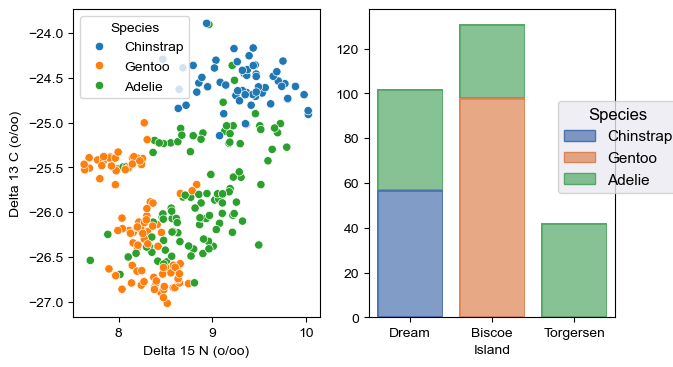

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (7, 4))

p1 = sns.scatterplot(train, x = 'Delta 15 N (o/oo)', y = 'Delta 13 C (o/oo)', hue = 'Species', ax = ax[0])
p2 = so.Plot(train, x = 'Island', color = 'Species').add(so.Bar(), so.Count(), so.Stack())
p2.on(ax[1]).show()

We can also take a closer look at the quantitative variables by looking at the mean and standard deviation values of a variety of features for each species. If the mean is not within a standard deviation of the means of the other two species, then it is likely that that feature could be a distinguinshable trait. With all four of these features, it appears that at least two species are always within a standard deviation of one another, meaning none of these traits can be used alone to classify the penguins.

Based on these obervations, it is likely that we will need to use some combination of features to fit an accurate model, as it appears that there is no feature or pair of features that can singlehandedly predict the species.

In [62]:
train.groupby("Species").aggregate({'Flipper Length (mm)': ['mean', 'std'],
                                    'Culmen Length (mm)': ['mean', 'std'],
                                    'Culmen Depth (mm)': ['mean', 'std'],
                                    'Body Mass (g)' : ['mean', 'std']})

Flipper Length (mm)           Culmen Length (mm)            \
                         mean       std               mean       std   
Species                                                                
Adelie             190.084034  6.689962          38.970588  2.640729   
Chinstrap          196.000000  7.423419          48.826316  3.450234   
Gentoo             216.752577  5.933715          47.073196  2.737415   

          Culmen Depth (mm)           Body Mass (g)              
                       mean       std          mean         std  
Species                                                          
Adelie            18.409244  1.217039   3718.487395  462.657007  
Chinstrap         18.366667  1.138033   3743.421053  407.423479  
Gentoo            14.914433  1.003431   5039.948454  498.861461

# Data Preparation
Our data requires a bit of preparation before it can be fed into our machine learning models. Our models only process quantitative variables, so we need to first represent our qualitative variables as numbers. Using the LabelEncoder, we convert the species labels to ternary form such that each species of penguin is represented by a $0$, $1$, or $2$. We drop the qualitative features that are dependent on the study, rather than an observation made of a penguin, which allows us to isolate the features that could be used to identify a penguin even if it came from a completely different study. Using get_dummies(), we convert the remaining qualitative variables to a set of dummy columns, which express each qualitative outcome as booleans. Our prepare_data function returns X_train: the data as a set of binaries and quantiative variables, and y_train: the ternary set of labels corresponding to each penguin in the study, which we can plug straight into our machine learning models!

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

From a brief examination of X_train, we can see that we successfully isolated the quantitative variables and converted the meaningful qualitative variables to a set of booleans!

In [64]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


# Model and Feature Selection
Our goal for our model is to select two quantitative features and a qualitative features that we can use to optimize the classification accuracy. For this analysis, we choose to do an exhaustive search, which tests the predictive accuracy of all combinations of one qualitative and two quantitative features and selects whichever combination scores the highest. Because we divided our qualitative features into dummy columns earlier, selecting qualitative features will involve using multiple qualitative columns (ex: using the "Island" feature will use three columns).

In [65]:
from itertools import combinations

all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

col_combs = []
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols 
    # print(cols)
    col_combs.append(cols) 

We first choose to examine the Logistic Regression model, which we use to determine which combinations of features score the highest. Iterating through the combinations of columns we created above, we can fit every possible combination of features to a Logistic Regression model and update our best score and best columns each time we find a model that works better than the previous best. 

In [ ]:
%%capture
from sklearn.linear_model import LogisticRegression
best_score = 0
best_cols = []
best_model = LogisticRegression()
for col in col_combs:
    LR = LogisticRegression()
    LR.fit(X_train[col], y_train)
    new_score = LR.score(X_train[col], y_train)
    if new_score > best_score:
        best_score = new_score
        best_cols = col
        best_model = LR

Our exhaustive search method returns that the three best features for classification are "Culmen Length", "Culmen Depth", and "Sex". When using these three features on our training dataset, we achieve a classification accuracy of $99.6$%!. 

In [67]:
print(best_score, best_cols)

0.99609375 ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE']


The goal with building a machine learning classifier is to be able to accurately classify data that we don't have the labels for. While a $99.6$% accuracy is certaintly exciting, it is not as impressive when we consider that the model has already seen the data that it is making predictions for. To test how applicable the model will be to new data, we can employ cross-validation, which trains the model and scores its predictions based on different subsets of the training data. When we calculate the mean of each subset's score, we find that the model has an average score of $98.4$%, meaning that the model will likely perform well on new data and is not subject to overfitting! We can also use this cross-validation score as a comparison to other machine learning models to determine which will be most effective.

In [73]:
%%capture
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(LR, X_train[best_cols], y_train, cv = 5)

In [74]:
cv_scores_LR.mean()

0.9844645550527904

For the sake of fairness, let's take a look at a second machine learning model to see if we can improve upon the results of our Logistic Regression model. We can fit a Random Forest Classifier model just like we do with Logisitic Regression and we find that it achieves $100$% accuracy on the training data set!

In [69]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train[best_cols], y_train)
RF.score(X_train[best_cols], y_train)

1.0

In [70]:
cv_scores_RF = cross_val_score(RF, X_train[best_cols], y_train, cv = 5)
cv_scores_RF.mean()

0.9765460030165913

Now comes the moment of truth: seeing how well our models work on a new set of data. We import and prepare the data the same way we did with our training data, which we then pass into each model's scoring method. We need to be careful not to refit the models on this data, as the whole idea is to test how well our previous fitting works on new data. As we see below, the Logistic Regression and Random Forest Classifier models score $100$% and $98.5$% accuracy, respectively. Success!

In [75]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)

X_test, y_test = prepare_data(test)
test_LR = best_model.score(X_test[best_cols], y_test)
test_RF = RF.score(X_test[best_cols], y_test)
print(test_LR, test_RF)

1.0 0.9852941176470589


# Visualizing the Model
Using a decision regions plot, we can visualize how our model assigns its labels. We can plot the two quantitative variables against one another, which creates a coordinate system with each point on the graph representing an individual penguin. Our models seek to define boundaries between each cluster of points, which in theory should divide the data into groups based on species. Because of the slightly superior performance of the Logisitic Regression model, we will examine its decision regions for both its training and testing data.

In [54]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Below are the decision regions for the training dataset, divided by "Sex", our selected qualitative variable. As we can see, the Logistic Regression model divides the coordinate space into three regions, each which correspond to a penguin species. When provided with new data, the model identifies where in the coordinate space that the new data point falls, and assigns a label based on whichever region it falls in. It appears that there are a few points that cross over to a different species' region, which would account for the less than perfect accuracy we observed earlier. While our first instinct may be to try and fix the model so that it achieves perfect accuracy, this is not necessarily the goal, as redrawing our lines to accomodate for outliers will likely cause overfitting that will not translate well to new data. As such, these regions indicate a very strong classifier!

C:\Users\omara\AppData\Local\Temp\ipykernel_24932\697242165.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


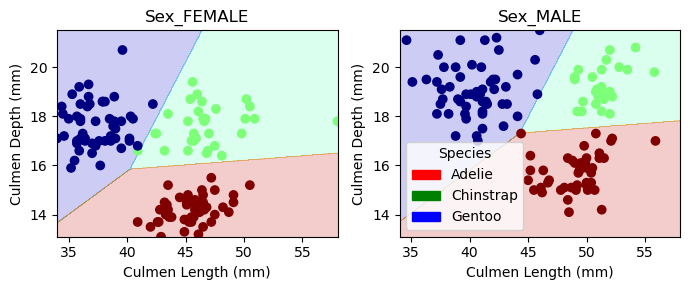

In [55]:
plot_regions(best_model, X_train[best_cols], y_train)

Below shows the same decision regions applied to the testing data, and as we would expect, the new data aligns very well with our trained regions. Success Again!

C:\Users\omara\AppData\Local\Temp\ipykernel_24932\697242165.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


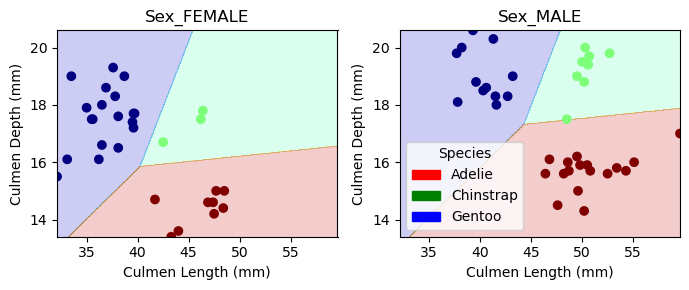

In [56]:
plot_regions(best_model, X_test[best_cols], y_test)

As a final check, it helps to generate a confusion matrix, which compares the real labels to the predicted labels to show where the classifier is making mistakes. For example, we may notice that the model tends to sometimes classify Adelie penguins as Gentoo penguins but never Gentoo penguins as Adelie penguins. This would perhaps help us identify similar features between the two or would maybe indicate that our model needs more training to be able to distinguish between the two. In our case, our model is fairly accurate, so it is a little tricky to make any strong conclusions about the errors in the model. Based on the confusion matrix for the training data below, it appears that one of the Chinstrap penguins was classified as a Gentoo penguin.

In [57]:
from sklearn.metrics import confusion_matrix

y_train_pred  = best_model.predict(X_train[best_cols])
C = confusion_matrix(y_train, y_train_pred)
C

array([[108,   0,   0],
       [  1,  55,   0],
       [  0,   0,  92]], dtype=int64)

# Discussion
Using our machine learning models, we show that we can learn trends in the data and use them to classify unlabeled data that the models haven't seen before. This can be a powerful tool as enabling machines to make educated decisions can allow for huge bounds in automation as well as allow for the indentification of trends that we would not be able to identify on our own. Based on the results above, it is possible to achieve optimal and effective clustering with only a few features, demonstrating how power and potential of these models. 